# Bug Priority Classification With Classic Models

## Objective
In this notebook, we build and evaluate a baseline text classification model for predicting bug priority levels (`Critical`, `High`, `Medium`, `Low`) from issue text.

## Notebook Goals
1. Load the preprocessed data and TF-IDF features.
2. Train a baseline text classification model.
    - XGBoost
    - LightGBM
3. Evaluate performance.
    - Confusion matrix
    - Precision
    - Recall
    - F1-score
    - Classification report
4. Identify areas for improvement for future models.
5. Perform hyperparameter tuning with RandomizedSearchCV

## Imports

In [2]:
# Standard data libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Evaluation Metrics
from sklearn.metrics import (
  confusion_matrix,
  precision_score,
  accuracy_score,
  recall_score,
  f1_score,
  classification_report
)

# Hyperparameter tuning
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Utilities
import joblib
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE


## Load Preprocessed Data and TF-IDF Features

In [3]:
processed_train_df = joblib.load("../../data/processed/processed_ISEC_train_df.joblib")
processed_test_df = joblib.load("../../data/processed/processed_ISEC_test_df.joblib")

In [4]:
processed_train_df.head()

,Issue_id,Component,Title,Description,Status,Resolution,Priority,Cleaned_Text
0,1700,Layout,font size 9px rounded down to 8px {font} {ll},There is a piece of code in the Windows GFX th...,VERIFIED,FIXED,0,font size rounded font piece code window gfx r...
1,7991,Plug-ins,Land OOP plugins in mozilla-central (preffed off),We need to land OOP plugins in mozilla-central...,RESOLVED,FIXED,0,land oop plugins mozilla central preffed need ...
2,1150,XPCOM,XP-COM Proxy code crashes when trying to AutoP...,(This bug imported from BugSplat; Netscapes in...,VERIFIED,FIXED,0,com proxy code crash trying autoproxy paramete...
3,6143,XUL,crash setting display:none on grid rows [@ nsG...,User-Agent: Mozilla/5.0 (Windows; U; Win...,VERIFIED,FIXED,0,crash setting display none grid row nsgrid get...
4,5952,Networking: Cache,limit the memory cache to a reasonable value,I have 1GB of RAM; so Im using 31MB of memory ...,VERIFIED,FIXED,0,limit memory cache reasonable value ram using ...


In [5]:
processed_test_df.head()

,Issue_id,Component,Title,Description,Status,Resolution,Cleaned_Text
0,6578,JavaScript Engine,Finalize yield syntax to match ES4/JS2 proposal,This tracks Python 2.5. Currently we allow; ;...,VERIFIED,FIXED,finalize yield syntax match proposal track pyt...
1,8050,Networking: Cache,e10s HTTP: offline application cache,I actually know very little about how applicat...,RESOLVED,FIXED,offline application cache actually know little...
2,5281,DOM: Core & HTML,[FIX]Add GetOwnerDocument on nsIContent or nsG...,See comments in bug 211440; the idea is to add...,RESOLVED,FIXED,fix add getownerdocument nsicontent nsgenerice...
3,7871,Layout: View Rendering,Text editing broken in Firebug edit mode and o...,Getting reports that editing is broken in Fire...,VERIFIED,FIXED,text editing broken firebug edit mode extensio...
4,2411,Plug-ins,shockwave movies redraw improperly on mac(nsbe...,From Bugzilla Helper:; User-Agent: Mozilla/4.7...,VERIFIED,DUPLICATE,shockwave movie redraw improperly mac nsbeta r...


In [6]:
X = processed_train_df["Cleaned_Text"]
y = processed_train_df["Priority"]

# Split data into train and test sets
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.2,
                                                  random_state=42,
                                                  stratify=y)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (42213,)
X_val shape: (10554,)
y_train shape: (42213,)
y_val shape: (10554,)


In [7]:
# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(
  max_features=5000,
  sublinear_tf=True,
  ngram_range=(1, 2),
  max_df=0.8,
  min_df=5
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

In [8]:
print("Shape of TF-IDF (train): ", X_train_tfidf.shape)
print("Shape of TF-IDF (Validation): ", X_val_tfidf.shape)

Shape of TF-IDF (train):  (42213, 5000)
Shape of TF-IDF (Validation):  (10554, 5000)


In [9]:
y_train.value_counts(), y_val.value_counts()

(Priority
 2    24755
 1     7524
 0     7152
 3     1829
 4      953
 Name: count, dtype: int64,
 Priority
 2    6189
 1    1881
 0    1789
 3     457
 4     238
 Name: count, dtype: int64)

In [10]:
# Check how many samples per class in training and validation sets
train_counts = y_train.value_counts()
val_counts = y_val.value_counts()

# Get total samples in each split
train_total = len(y_train)
val_total = len(y_val)

# Convert counts to relative frequencies
train_percentages = round((train_counts / train_total) * 100, 1)
val_percentages = round((val_counts / val_total) * 100, 1)

In [11]:
# Compare distribution
comparison_table = pd.DataFrame({
  "Train %": train_percentages,
  "Validation %": val_percentages
})
comparison_table

,Train %,Validation %
Priority,,
2,58.6,58.6
1,17.8,17.8
0,16.9,17.0
3,4.3,4.3
4,2.3,2.3


## Apply SMOTE to Balance the Classes

In [12]:
print("Before SMOTE: ", np.bincount(y_train))

Before SMOTE:  [ 7152  7524 24755  1829   953]


In [13]:
smote = SMOTE(random_state=42)
X_train_tfidf_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

In [14]:
print("After SMOTE: ", np.bincount(y_train_resampled))

After SMOTE:  [24755 24755 24755 24755 24755]


## Train Baseline Models

- XGBoost
- LightGBM

In [15]:
# Put models in a dictionary
models = {
  "XGBoost": XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softmax",
    num_class=len(np.unique(y_train_resampled)),
    random_state=42,
    n_jobs=-1
  ),
  "LightGBM": LGBMClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=-1,  # No limit
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
  )
}


In [16]:
# Create a function to fit and score models
def fit_and_score(models, X_train_tfidf, X_val_tfidf, y_train, y_val):
  """
  Fit machine learning models on training data and evaluate their accuracy on test data.

  Args:
      models (dict): A dictionary of model name strings to instantiated model objects.
      X_train_tfidf (array-like or sparse matrix): Training feature matrix.
      X_val_tfidf (array-like or sparse matrix): Validation feature matrix.
      y_train (array-like): Training labels.
      y_val (array-like): Validation labels.

  Returns:
      dict: A dictionary mapping model names to their accuracy scores on the test set.
  """
  model_scores = {}
  
  for name, model in models.items():
    model.fit(X_train_tfidf_resampled, y_train_resampled)
    model_scores[name] = model.score(X_val_tfidf, y_val)
  
  return model_scores

In [17]:
model_scores = fit_and_score(
  models=models,
  X_train_tfidf=X_train_tfidf_resampled,
  X_val_tfidf=X_val_tfidf,
  y_train=y_train_resampled,
  y_val=y_val
)

model_scores

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.520250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 860937
[LightGBM] [Info] Number of data points in the train set: 123775, number of used features: 4966
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438


c:\Users\rusty\miniconda3\envs\bug-triage-env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


{'XGBoost': 0.6092476786052682, 'LightGBM': 0.6022361190070116}

## Evaluate performance

- Confusion matrix
- Precision
- Recall
- F1-score
- Classification report

(Optional)
- Accuracy
- Cross-validation
- Feature importance

In [18]:
def evalute_models(models, X_train, X_val, y_train, y_val):
  """
  Evaluate multiple classification models on test data.

  Args:
      models (dict): Dictionary of trained models {name: model}.
      X_test: Test features.
      y_test: True labels.
      plot_cm (bool, optional): Whether to display confusion matrices. Defaults to True.
      
  Returns:
    eval_df (DataFrame): Metrics for all models, sorted by weighted F1-score.
  """
  eval_results = []
  
  for name, model in models.items():
    y_pred = model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1_macro = f1_score(y_val, y_pred, average='macro')
    f1_weighted = f1_score(y_val, y_pred, average='weighted')
    
    eval_results.append({
      "model": name,
      "accuracy": accuracy,
      "precision": precision,
      "recall": recall,
      "f1 macro": f1_macro,
      "f1 weighted": f1_weighted
    })
    
    print(f"{name}: Accuracy={accuracy:.3f}, F1 Macro={f1_macro:.3f}, F1 Weighted={f1_weighted:.3f}")
    print(classification_report(y_val, y_pred))
    
  eval_df = pd.DataFrame(eval_results).sort_values(by="f1 macro", ascending=False)
  return eval_df

In [19]:
eval_df = evalute_models(
  models=models,
  X_train=X_train_tfidf_resampled,
  X_val=X_val_tfidf,
  y_train=y_train_resampled,
  y_val=y_val
)

XGBoost: Accuracy=0.609, F1 Macro=0.350, F1 Weighted=0.574
              precision    recall  f1-score   support

           0       0.45      0.36      0.40      1789
           1       0.37      0.20      0.26      1881
           2       0.69      0.86      0.77      6189
           3       0.16      0.10      0.12       457
           4       0.27      0.16      0.20       238

    accuracy                           0.61     10554
   macro avg       0.39      0.34      0.35     10554
weighted avg       0.56      0.61      0.57     10554



c:\Users\rusty\miniconda3\envs\bug-triage-env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM: Accuracy=0.602, F1 Macro=0.359, F1 Weighted=0.579
              precision    recall  f1-score   support

           0       0.44      0.37      0.40      1789
           1       0.35      0.25      0.29      1881
           2       0.71      0.83      0.76      6189
           3       0.17      0.12      0.14       457
           4       0.24      0.16      0.20       238

    accuracy                           0.60     10554
   macro avg       0.38      0.35      0.36     10554
weighted avg       0.57      0.60      0.58     10554



In [20]:
display(eval_df)

,model,accuracy,precision,recall,f1 macro,f1 weighted
1,LightGBM,0.602236,0.566228,0.602236,0.359472,0.579103
0,XGBoost,0.609248,0.561439,0.609248,0.350336,0.573668


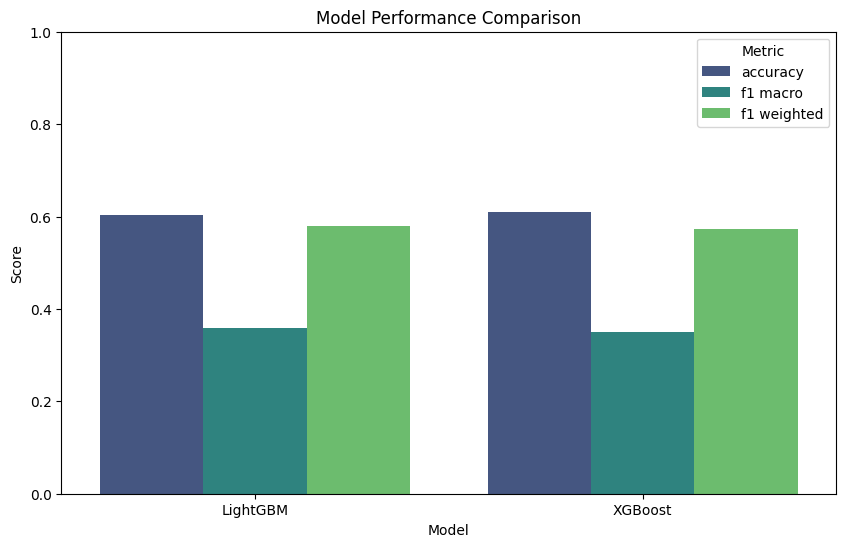

In [21]:
metrics_df = eval_df.copy()
metrics_plot = metrics_df.melt(
  id_vars="model",
  value_vars=["accuracy", "f1 macro", "f1 weighted"],
  var_name="metric",
  value_name="score"
)

plt.figure(figsize=(10,6))
sns.barplot(
  x="model",
  y="score",
  hue="metric",
  data=metrics_plot,
  palette="viridis"
)
plt.title("Model Performance Comparison")
plt.ylim(0,1)
plt.ylabel("Score")
plt.xlabel("Model")
plt.legend(title="Metric")
plt.show()

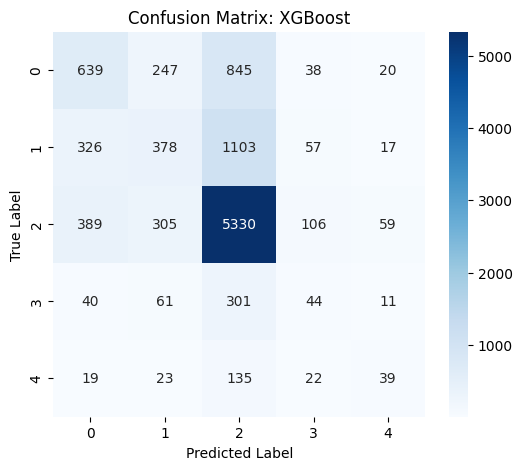

c:\Users\rusty\miniconda3\envs\bug-triage-env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


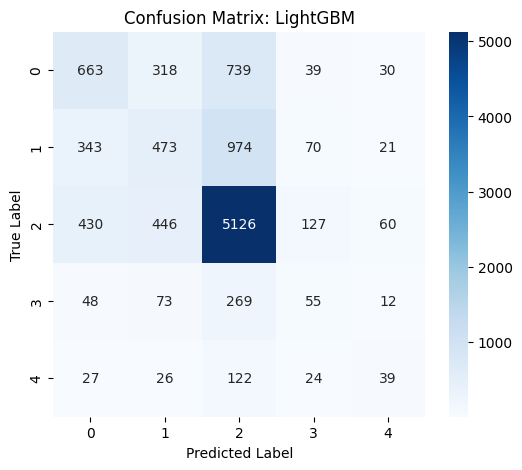

In [22]:
labels = sorted(y_val.unique())

for name, model in models.items():
  y_pred = model.predict(X_val_tfidf)
  cm = confusion_matrix(y_val, y_pred, labels=labels)
  
  plt.figure(figsize=(6,5))
  sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
  )
  plt.title(f"Confusion Matrix: {name}")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()

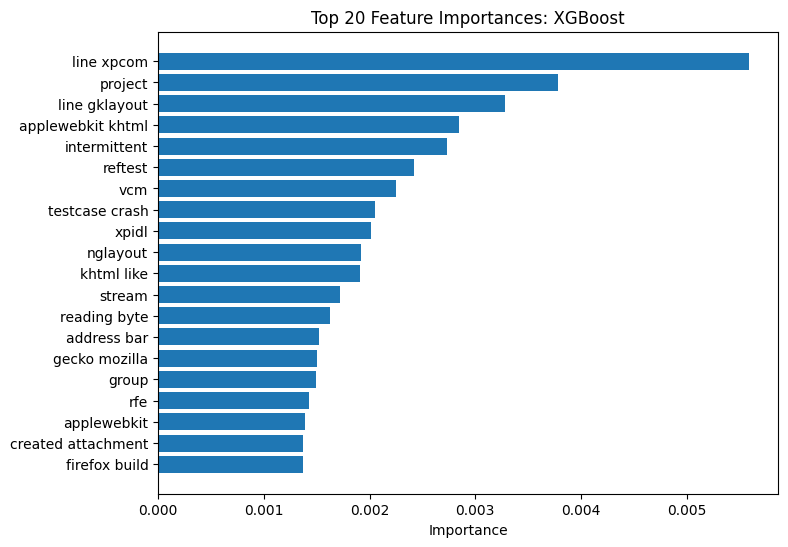

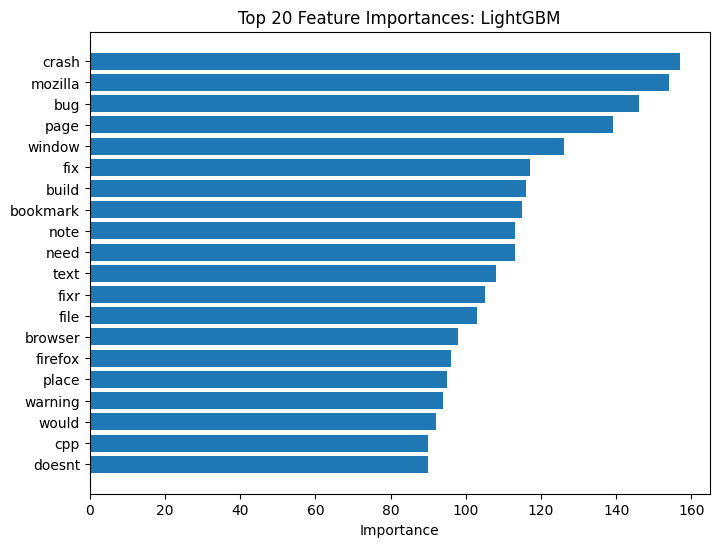

In [23]:
for name, model in models.items():
  if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
    top_n = 20
    indices = np.argsort(importances)[-top_n:]
    
    plt.figure(figsize=(8,6))
    plt.barh(range(top_n), importances[indices], align="center")
    plt.yticks(range(top_n), [tfidf.get_feature_names_out()[i] for i in indices])
    plt.title(f"Top {top_n} Feature Importances: {name}")
    plt.xlabel("Importance")
    plt.show()

## Hyperparameter Tuning with RandomizedSearchCV

In [24]:
model_scores

{'XGBoost': 0.6092476786052682, 'LightGBM': 0.6022361190070116}

In [25]:
# Create a hyperparameter grid for XGBoost
xgb_grid = {
  "n_estimators": [100, 200],
  "max_depth": [6, 10],
  "learning_rate": [0.05, 0.1],
  "subsample": [0.8],
  "colsample_bytree": [0.8]
}

# Tune XGBoost
rs_xgb = RandomizedSearchCV(
  XGBClassifier(
    objective="multi:softmax", 
    num_class=len(np.unique(y_train_resampled)), 
    random_state=42, 
    n_jobs=1
  ),
  param_distributions=xgb_grid,
  n_iter=8,
  scoring="f1_weighted",
  cv=3,
  random_state=42,
  verbose=2,
  n_jobs=2
)

rs_xgb.fit(X_train_tfidf_resampled, y_train_resampled)



Fitting 3 folds for each of 8 candidates, totalling 24 fits


,estimator,"XGBClassifier..._class=5, ...)"
,param_distributions,"{'colsample_bytree': [0.8], 'learning_rate': [0.05, 0.1], 'max_depth': [6, 10], 'n_estimators': [100, 200], ...}"
,n_iter,8
,scoring,'f1_weighted'
,n_jobs,2
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [26]:
print("XGBoost best params: ", rs_xgb.best_params_)
print("XGBoost best F1 weighted: ", rs_xgb.best_score_)

XGBoost best params:  {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
XGBoost best F1 weighted:  0.7892878765634564


In [27]:
# Create a hyperparameter grid for LightGBM
lgbm_grid = {
  "n_estimators": [100, 200],
  "max_depth": [8, 10],
  "learning_rate": [0.05, 0.1],
  "num_leaves": [31, 50],
  "subsample": [0.8],
  "colsample_bytree": [0.8]
}

# Tune LightGBM
rs_lgbm = RandomizedSearchCV(
  LGBMClassifier(
    random_state=42, 
    n_jobs=1,
    class_weight="balanced"
  ),
  param_distributions=lgbm_grid,
  n_iter=8,
  scoring="f1_weighted",
  cv=3,
  random_state=42,
  verbose=2,
  n_jobs=2
)

rs_lgbm.fit(X_train_tfidf_resampled, y_train_resampled)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.113065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 860937
[LightGBM] [Info] Number of data points in the train set: 123775, number of used features: 4966
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

,estimator,LGBMClassifie...ndom_state=42)
,param_distributions,"{'colsample_bytree': [0.8], 'learning_rate': [0.05, 0.1], 'max_depth': [8, 10], 'n_estimators': [100, 200], ...}"
,n_iter,8
,scoring,'f1_weighted'
,n_jobs,2
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [28]:
print("LightGBM best params: ", rs_lgbm.best_params_)
print("LightGBM best F1 weighted: ", rs_lgbm.best_score_)

LightGBM best params:  {'subsample': 0.8, 'num_leaves': 31, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
LightGBM best F1 weighted:  0.7850168397202318


In [29]:
tuned_models = {
  "XGBoost (Tuned)": rs_xgb.best_estimator_,
  "LightGBM (Tuned)": rs_lgbm.best_estimator_
}

In [30]:
tuned_eval_df = evalute_models(
  tuned_models,
  X_train=X_train_tfidf_resampled,
  X_val=X_val_tfidf,
  y_train=y_train_resampled,
  y_val=y_val
  )
display(tuned_eval_df)

XGBoost (Tuned): Accuracy=0.609, F1 Macro=0.347, F1 Weighted=0.573
              precision    recall  f1-score   support

           0       0.45      0.35      0.40      1789
           1       0.37      0.20      0.26      1881
           2       0.69      0.86      0.77      6189
           3       0.16      0.09      0.11       457
           4       0.26      0.16      0.20       238

    accuracy                           0.61     10554
   macro avg       0.39      0.33      0.35     10554
weighted avg       0.56      0.61      0.57     10554



c:\Users\rusty\miniconda3\envs\bug-triage-env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM (Tuned): Accuracy=0.598, F1 Macro=0.360, F1 Weighted=0.575
              precision    recall  f1-score   support

           0       0.43      0.38      0.41      1789
           1       0.35      0.22      0.27      1881
           2       0.71      0.82      0.76      6189
           3       0.15      0.12      0.13       457
           4       0.25      0.21      0.23       238

    accuracy                           0.60     10554
   macro avg       0.38      0.35      0.36     10554
weighted avg       0.56      0.60      0.57     10554



,model,accuracy,precision,recall,f1 macro,f1 weighted
1,LightGBM (Tuned),0.597593,0.563385,0.597593,0.360022,0.574828
0,XGBoost (Tuned),0.608963,0.560356,0.608963,0.346705,0.572704


In [31]:
eval_df_baseline = eval_df.copy()
eval_df_baseline["Type"] = "Baseline"

eval_df_tuned = tuned_eval_df.copy()
eval_df_tuned["Type"] = "Tuned"

In [32]:
eval_comparison_df = pd.concat([eval_df_baseline, eval_df_tuned], ignore_index=True)
display(eval_comparison_df)

,model,accuracy,precision,recall,f1 macro,f1 weighted,Type
0,LightGBM,0.602236,0.566228,0.602236,0.359472,0.579103,Baseline
1,XGBoost,0.609248,0.561439,0.609248,0.350336,0.573668,Baseline
2,LightGBM (Tuned),0.597593,0.563385,0.597593,0.360022,0.574828,Tuned
3,XGBoost (Tuned),0.608963,0.560356,0.608963,0.346705,0.572704,Tuned


## Baseline vs. Tuned Model Summary

The evaluation shows that both baseline and tuned versions of XGBoost and LightGBM perform similarly:

- **Accuracy**: Slight differences , with both XGBoost and LGBM model essentially unchanged.
- **Weighted F1**: Minor improvements or declines after tuning.
- **Macro F1**: Very small changes, indicating class-wise performance stayed mostly the same.

**Key Observations**:
- Hyperparameter tuning did not produce meaningful improvements in overall or class-balanced metrics.
- Given the minimal gains and additional complexity of tuning, the **baseline models are retained** for simplicity and reproducibility.
- LightGBM is a good choice for a quick, interpretable, and efficient model pipeline for text-based bug priority classification.

In short, the baseline models provide stable and reliable performance without the overhead of extensive hyperparameter tuning.

## Save the Trained Model

In [ ]:
# Save as a pipeline that icludes the TF-IDF vectorizer and the LightGBM model
baseline_pipeline = Pipeline([
  ("tfidf", tfidf),
  ("lgbm", models["LightGBM"])
])

joblib.dump(baseline_pipeline, filename="../models/classic/baseline_lgbm_pipeline.joblib")
print("Baseline LightGBM Pipeline saved successfully!")

Baseline LightGBM Pipeline saved successfully!
